In [1]:
import sys
import numpy as np
import sacc
import yaml
sys.path.insert(1, '/home/jaimerz/Documents/UCL/pacc')
import pacc

In [2]:
s = sacc.Sacc.load_fits("/home/jaimerz/Documents/UCL/3x2_analytical/data/HSC/HSC.sacc")
y = yaml.load(open("/home/jaimerz/Documents/UCL/3x2_analytical/data/HSC/HSC.yml"), Loader=yaml.FullLoader)

In [3]:
cle = pacc.ClsEnsemble(s,y)

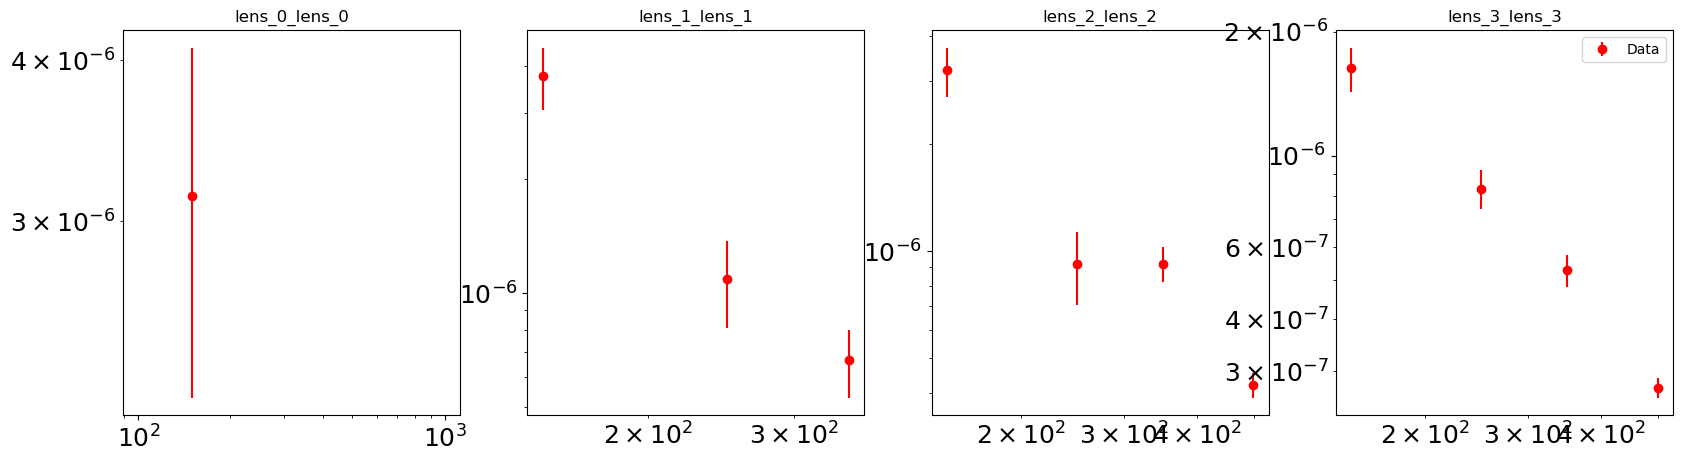

In [4]:
pacc.plot_cls([cle], [['lens_0', 'lens_0'],
              ['lens_1', 'lens_1'],
              ['lens_2', 'lens_2'], 
              ['lens_3', 'lens_3']])

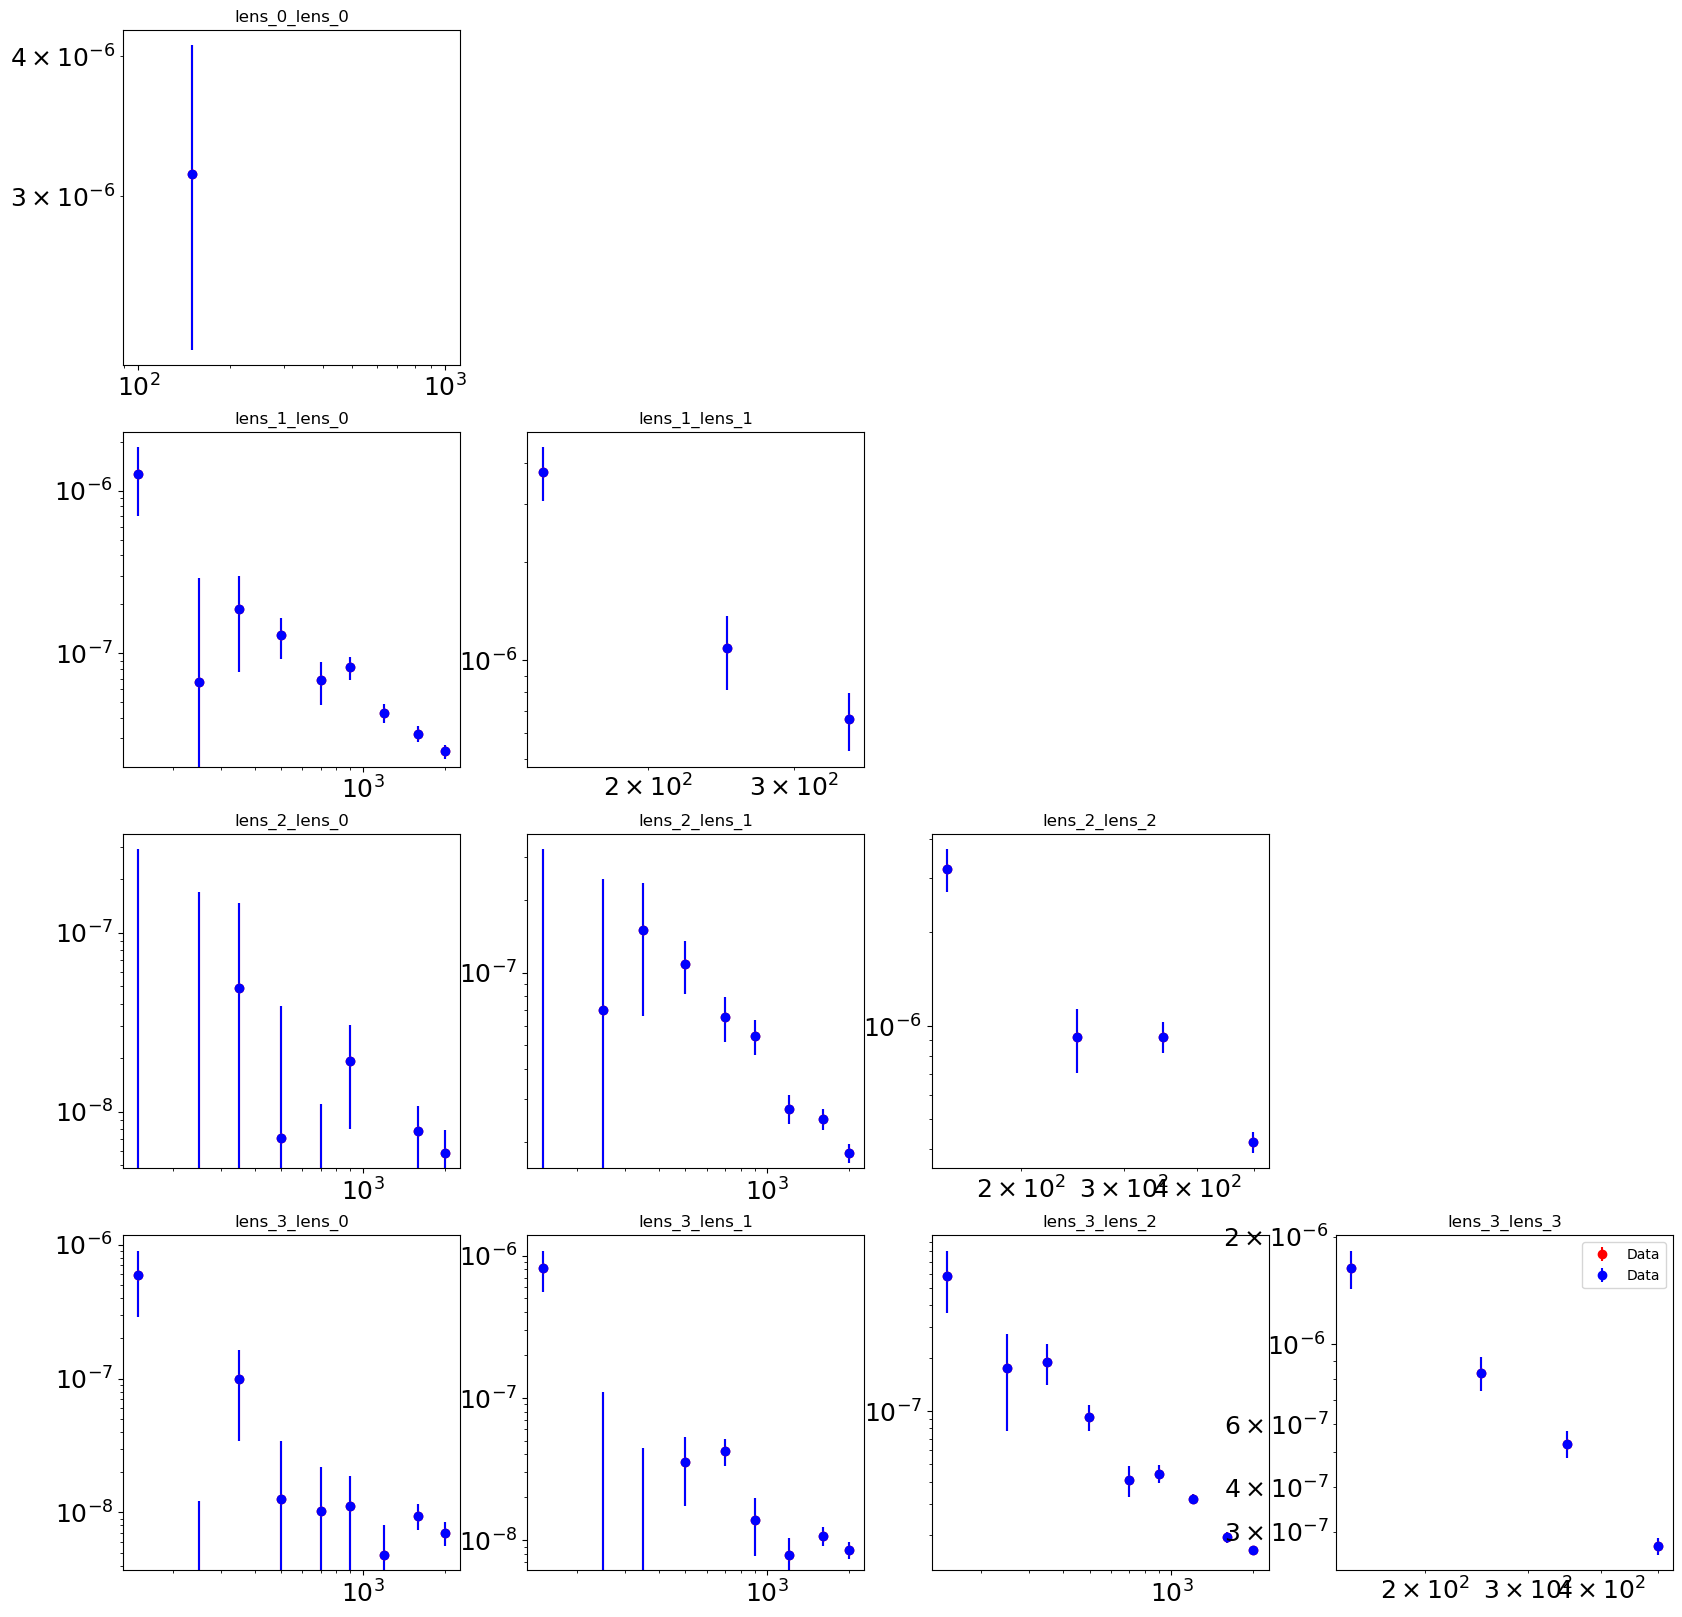

In [5]:
pacc.plot_cls([cle, cle], cle.pairs[:10])